In [2]:
!pip3 install ftfy

     |████████████████████████████████| 61kB 4.6MB/s 
  Created wheel for ftfy: filename=ftfy-5.7-cp36-none-any.whl size=44593 sha256=4fbcc73f0df5621688bf3c1804be25565fcfab2405d186e7ce465f9dd754ffb0
  Stored in directory: /root/.cache/pip/wheels/8e/da/59/6c8925d571aacade638a0f515960c21c0887af1bfe31908fbf
Successfully built ftfy


In [0]:
import os
import pickle
import numpy as np
from math import inf
from tqdm import tqdm
import h5py
import ftfy
from matplotlib import pyplot as plt

In [9]:
LOCAL_PATH = "/home/diedre/Dropbox/aUNICAMP/phd/courses/deep_learning_nlp/PTT5"
if not os.path.isdir(LOCAL_PATH):
    print("On cloud")
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    DATA_PATH = "/content/drive/Shared drives/PTT5_Dados/brwac/brwac.vert"
else:
    DATA_PATH = "/home/diedre/Dropbox/aUNICAMP/phd/courses/deep_learning_nlp/PTT5/brwac.vert"

On cloud
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls "{DATA_PATH}"

'''total_lines = 0
with open(DATA_PATH, 'r') as fin:
    for line in fin:
        total_lines += 1

print(f"Total lines in vertical brwac: {total_lines}")'''

total_lines = 4050804143
print("Total lines in vertical brwac: 4050804143")

/home/diedre/Dropbox/aUNICAMP/phd/courses/deep_learning_nlp/PTT5/brwac.vert
Total lines in vertical brwac: 4050804143


# Split into sentences

In [0]:
'''skip_tags = ['<g/>', '<p>', '</p>', '</doc>']
begin_tags = ['<s>', '<s>\n']
end_tags = ['</s>', '</s>\n']

skip_tags_plus_carriage = [tag + '\n' for tag in skip_tags]

with open('brwac_homemade.txt', 'w') as output:
    with open(DATA_PATH, 'r') as fin:
        add_space = 1
        iterator = tqdm(fin, leave=True, position=0, total=total_lines)
        for line in iterator:
            if line in skip_tags_plus_carriage:  # skip these tags
                if line == '<g/>\n':  # dont add space with <g>
                    add_space = 0
            elif line in begin_tags:  # begin sentence
                sentence = ''
            elif line in end_tags:  # end sentence
                output.write(sentence + '\n')
            elif not(line.strip().startswith('<doc')):  # if not begining line, fill sentence
                sentence = (add_space * ' ').join([sentence, line.replace('\n', '')])
                add_space = 1'''

100%|██████████| 4050804143/4050804143 [1:03:58<00:00, 1055239.99it/s]


# Split into set of sentences near 512 len

In [0]:
skip_tags = ['<g/>', '<p>', '</p>']
begin_tags = ['<s>', '<s>\n']
end_tags = ['</s>', '</s>\n']
end_text_tags = ['</doc>', '</doc>\n']

skip_tags_plus_carriage = [tag + '\n' for tag in skip_tags]


def fix_encode_write(text, output):
    try:
        final_text = text.strip() + '\n'
        output.write(ftfy.fix_encoding(final_text))
    except Exception as e:
        print(f"Encoding fix error? {e}\nTrying to save raw text")
        output.write(final_text)


text = ''
limit = inf

with open('brwac_512.txt', 'w') as output:
    with open(DATA_PATH, 'r') as fin:
        add_space = 1
        iterator = tqdm(fin, leave=True, position=0, total=total_lines)
        for i, line in enumerate(iterator):
            if i > limit:
                break

            if line in skip_tags_plus_carriage:  # skip these tags
                if line == '<g/>\n':  # dont add space with <g>
                    add_space = 0
            elif line in begin_tags:  # begin sentence
                sentence = ''
            elif line in end_tags:  # end sentence
                expanded_text = ''.join([text, sentence])
                
                if len(expanded_text.split()) >= 512:  # concat with next sentence went over limit, write text chunk
                    fix_encode_write(text, output)
                    text = ''
                else:  # text too small yet, keep increasing its size
                    text = expanded_text
                    sentence = ''

            elif line in end_text_tags:
                # Flush when end doc is found
                if len(text.split()) > 0:
                    fix_encode_write(text, output)
                elif len(sentence.split()) > 0:
                    fix_encode_write(sentence, output)
                text = ''
                sentence = ''
            elif not(line.strip().startswith('<doc')):  # if not begining line, fill sentence
                sentence = (add_space * ' ').join([sentence, line.replace('\n', '')])
                add_space = 1
            

100%|██████████| 4050804143/4050804143 [4:22:28<00:00, 257211.42it/s]


In [10]:
# Mean: 360
wcs = []
with open("/content/drive/Shared drives/PTT5_Dados/brwac/brwac_512.txt", 'r') as brwac512:
    for line in brwac512:
        wcs.append(len(line.split()))

print(np.array(wcs).mean())

FileNotFoundError: ignored

In [11]:
# txt_size = 7361359
txt_size = 0
with open("/content/drive/Shared drives/PTT5_Dados/brwac/brwac_512.txt", 'r') as txt:
    for line in tqdm(txt, desc="Counting lines", leave=True, position=0):
        txt_size += 1
txt_size


Counting lines: 7361359it [31:13, 3929.64it/s]


7361359

# 512 Dataset Statistics

In [0]:
pkl_file = "wc_per_sentence.pkl"
if os.path.isfile(pkl_file):
    print("Word count per sentence already found.")
    with open(pkl_file, 'rb') as pkl:
        wc_per_sentence = pickle.load(pkl)
else:
    print("Building word count per sentence...")
    wc_per_sentence = np.zeros(txt_size, dtype=np.int)
    with open("brwac_512.txt", 'r') as text:
        for i, line in tqdm(enumerate(text), leave=True, position=0, total=txt_size):
            try:
                wc_per_sentence[i] = len(line.split())
            except IndexError:
                print('Problem! txt file is bigger than brwacs["all"]?')
                break
                
        with open(pkl_file, 'wb') as pkl_output:
            pickle.dump(wc_per_sentence, pkl_output)

  0%|          | 2789/7361359 [00:00<04:23, 27882.65it/s]

Building word count per sentence...


100%|██████████| 7361359/7361359 [03:36<00:00, 34019.90it/s]


In [0]:
total_sentences, total_words = txt_size, wc_per_sentence.sum()
mean, std = int(wc_per_sentence.mean()), int(wc_per_sentence.std())
largest, smallest = wc_per_sentence.max(), wc_per_sentence.min()

print(f"Total number of sentences: {total_sentences}")
print(f"Total number of words: {total_words}")
print(f"Mean words per sentence: {mean}")
print(f"Standard deviation words per sentence: {std}")
print(f"Largest sentence: {largest}")
print(f"Smallest sentence: {smallest}")

Total number of sentences: 7361359
Total number of words: 2656275093
Mean words per sentence: 360
Standard deviation words per sentence: 169
Largest sentence: 17040
Smallest sentence: 0


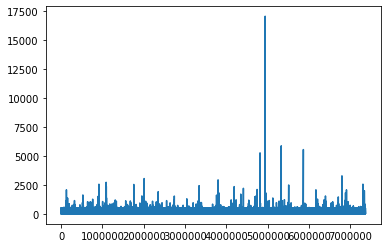

In [0]:
plt.plot(range(len(wc_per_sentence)), wc_per_sentence)
plt.show()

In [0]:
with open("brwac_512.txt", 'r') as txt:
    with h5py.File("brwac.hdf5", 'w') as h5txt:
        grp = h5txt.create_group('text')
        dataset = grp.create_dataset("lines", (txt_size,), dtype=h5py.string_dtype())
        for i, line in enumerate(tqdm(txt, desc="Creating dataset", leave=True, position=0, total=txt_size, mininterval=1)):
            dataset[i] = line.strip()

Creating dataset: 100%|██████████| 7361359/7361359 [19:38<00:00, 6244.91it/s]


In [0]:
with h5py.File("brwac.hdf5", 'r') as h5txt:
    db = h5txt["text"]["lines"]
    print(db)
    print(db.shape)
    print(db[0])
    print(db[-1])


<HDF5 dataset "lines": shape (7361359,), type "|O">
(7361359,)
Conteúdo recente ESPUMA MARROM CHAMADA "NINGUÉM MERECE" 31 de Agosto de 2015, 7:07 , por paulo soavinski - | No one following this article yet. Visualizado 202 vezes JORNAL ELETRÔNICO DA ILHA DO MEL Uma espuma marrom escuro tem aparecido com frequência na Praia de Fora. Na faixa de areia ela aparece disseminada e não chama muito a atenção. No Buraco do Aipo, com muitas pedras, ela aparece concentrada. É fácil saber que esta espuma estranha está lá, quando venta. Pequenos algodões de espuma começam a flutuar no espaço, pertinho da Praia do Saquinho. Quem pode ajudar na coleta deste material, envio a laboratório renomado e pagamento de análises, favor entrar em contato com o site.
Posts do dia 3 abril 2012 A partir desta quarta-feira, os leitores de Zero Hora terão um endereço certo na internet para tirar suas dúvidas sobre as eleições deste ano. Um guia completo trará informações sobre como regularizar o título, regras da pr